In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b10','b25','b50','b75'],'fi':['t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_b10_b25_b50_b75_t1_mask_t1_native_k5_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 474)
(631390, 1)
validation
(74368, 474)
(74368, 1)
test
(85358, 474)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 474)]             0         


 dense (Dense)               (None, 1024)              486400    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1175553 (4.48 MB)


Trainable params: 1175553 (4.48 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/64 [..............................] - ETA: 1:36 - loss: 0.0222 - STD: 2.5037e-04 - MAE: 0.1391

 4/64 [>.............................] - ETA: 1s - loss: 0.0224 - STD: 2.8233e-04 - MAE: 0.1099  

 7/64 [==>...........................] - ETA: 1s - loss: 0.0192 - STD: 2.8917e-04 - MAE: 0.0968

10/64 [===>..........................] - ETA: 1s - loss: 0.0183 - STD: 3.1804e-04 - MAE: 0.1004

13/64 [=====>........................] - ETA: 0s - loss: 0.0172 - STD: 3.3646e-04 - MAE: 0.0919

16/64 [======>.......................] - ETA: 0s - loss: 0.0167 - STD: 3.5419e-04 - MAE: 0.0865

19/64 [=======>......................] - ETA: 0s - loss: 0.0161 - STD: 3.8561e-04 - MAE: 0.0837

22/64 [=========>....................] - ETA: 0s - loss: 0.0158 - STD: 4.2484e-04 - MAE: 0.0846

25/64 [==========>...................] - ETA: 0s - loss: 0.0154 - STD: 4.6082e-04 - MAE: 0.0835

28/64 [============>.................] - ETA: 0s - loss: 0.0152 - STD: 4.9169e-04 - MAE: 0.0811

31/64 [=============>................] - ETA: 0s - loss: 0.0149 - STD: 5.2682e-04 - MAE: 0.0793

34/64 [==============>...............] - ETA: 0s - loss: 0.0147 - STD: 5.7163e-04 - MAE: 0.0789

37/64 [================>.............] - ETA: 0s - loss: 0.0146 - STD: 6.2250e-04 - MAE: 0.0789

40/64 [=================>............] - ETA: 0s - loss: 0.0144 - STD: 6.7376e-04 - MAE: 0.0781

43/64 [===================>..........] - ETA: 0s - loss: 0.0143 - STD: 7.2969e-04 - MAE: 0.0771

46/64 [====================>.........] - ETA: 0s - loss: 0.0141 - STD: 7.9689e-04 - MAE: 0.0764

47/64 [=====================>........] - ETA: 0s - loss: 0.0141 - STD: 8.2185e-04 - MAE: 0.0762

50/64 [======================>.......] - ETA: 0s - loss: 0.0140 - STD: 9.0976e-04 - MAE: 0.0761

53/64 [=======================>......] - ETA: 0s - loss: 0.0139 - STD: 0.0010 - MAE: 0.0758    

56/64 [=========================>....] - ETA: 0s - loss: 0.0139 - STD: 0.0011 - MAE: 0.0753

59/64 [==========================>...] - ETA: 0s - loss: 0.0138 - STD: 0.0013 - MAE: 0.0750

62/64 [============================>.] - ETA: 0s - loss: 0.0137 - STD: 0.0015 - MAE: 0.0747

64/64 [==============================] - 4s 41ms/step - loss: 0.0136 - STD: 0.0016 - MAE: 0.0744 - val_loss: 0.0156 - val_STD: 0.0058 - val_MAE: 0.0730


Epoch 2/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0114 - STD: 0.0071 - MAE: 0.0636

 4/64 [>.............................] - ETA: 1s - loss: 0.0114 - STD: 0.0081 - MAE: 0.0645

 7/64 [==>...........................] - ETA: 1s - loss: 0.0111 - STD: 0.0096 - MAE: 0.0653

10/64 [===>..........................] - ETA: 1s - loss: 0.0108 - STD: 0.0114 - MAE: 0.0641

13/64 [=====>........................] - ETA: 0s - loss: 0.0106 - STD: 0.0138 - MAE: 0.0632

16/64 [======>.......................] - ETA: 0s - loss: 0.0101 - STD: 0.0171 - MAE: 0.0619

19/64 [=======>......................] - ETA: 0s - loss: 0.0096 - STD: 0.0214 - MAE: 0.0599

22/64 [=========>....................] - ETA: 0s - loss: 0.0090 - STD: 0.0270 - MAE: 0.0579

26/64 [===========>..................] - ETA: 0s - loss: 0.0085 - STD: 0.0362 - MAE: 0.0557

29/64 [============>.................] - ETA: 0s - loss: 0.0080 - STD: 0.0429 - MAE: 0.0545

32/64 [==============>...............] - ETA: 0s - loss: 0.0076 - STD: 0.0481 - MAE: 0.0532

35/64 [===============>..............] - ETA: 0s - loss: 0.0073 - STD: 0.0517 - MAE: 0.0520

38/64 [================>.............] - ETA: 0s - loss: 0.0070 - STD: 0.0545 - MAE: 0.0509

41/64 [==================>...........] - ETA: 0s - loss: 0.0067 - STD: 0.0573 - MAE: 0.0498

44/64 [===================>..........] - ETA: 0s - loss: 0.0065 - STD: 0.0604 - MAE: 0.0490

47/64 [=====================>........] - ETA: 0s - loss: 0.0063 - STD: 0.0630 - MAE: 0.0482

50/64 [======================>.......] - ETA: 0s - loss: 0.0061 - STD: 0.0649 - MAE: 0.0474

53/64 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0665 - MAE: 0.0466

56/64 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0684 - MAE: 0.0460

59/64 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0700 - MAE: 0.0454

62/64 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0713 - MAE: 0.0448

64/64 [==============================] - 1s 20ms/step - loss: 0.0054 - STD: 0.0721 - MAE: 0.0445 - val_loss: 0.0042 - val_STD: 0.0810 - val_MAE: 0.0394


Epoch 3/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0025 - STD: 0.0952 - MAE: 0.0325

 4/64 [>.............................] - ETA: 1s - loss: 0.0025 - STD: 0.0990 - MAE: 0.0327

 7/64 [==>...........................] - ETA: 1s - loss: 0.0025 - STD: 0.1006 - MAE: 0.0328

10/64 [===>..........................] - ETA: 1s - loss: 0.0025 - STD: 0.1000 - MAE: 0.0328

13/64 [=====>........................] - ETA: 1s - loss: 0.0025 - STD: 0.0998 - MAE: 0.0328

17/64 [======>.......................] - ETA: 0s - loss: 0.0025 - STD: 0.1001 - MAE: 0.0327

20/64 [========>.....................] - ETA: 0s - loss: 0.0024 - STD: 0.1001 - MAE: 0.0326

23/64 [=========>....................] - ETA: 0s - loss: 0.0024 - STD: 0.1003 - MAE: 0.0325

26/64 [===========>..................] - ETA: 0s - loss: 0.0024 - STD: 0.1006 - MAE: 0.0324

29/64 [============>.................] - ETA: 0s - loss: 0.0024 - STD: 0.1007 - MAE: 0.0323

32/64 [==============>...............] - ETA: 0s - loss: 0.0024 - STD: 0.1007 - MAE: 0.0322

35/64 [===============>..............] - ETA: 0s - loss: 0.0023 - STD: 0.1008 - MAE: 0.0322

38/64 [================>.............] - ETA: 0s - loss: 0.0023 - STD: 0.1010 - MAE: 0.0321

41/64 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.1011 - MAE: 0.0320

44/64 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.1013 - MAE: 0.0320

47/64 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.1013 - MAE: 0.0319

50/64 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1013 - MAE: 0.0319

53/64 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1013 - MAE: 0.0318

56/64 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1015 - MAE: 0.0318

59/64 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1015 - MAE: 0.0317

62/64 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1015 - MAE: 0.0317

64/64 [==============================] - 1s 20ms/step - loss: 0.0022 - STD: 0.1016 - MAE: 0.0317 - val_loss: 0.0026 - val_STD: 0.0836 - val_MAE: 0.0334


Epoch 4/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0022 - STD: 0.0978 - MAE: 0.0314

 4/64 [>.............................] - ETA: 1s - loss: 0.0021 - STD: 0.1025 - MAE: 0.0314

 7/64 [==>...........................] - ETA: 1s - loss: 0.0021 - STD: 0.1025 - MAE: 0.0310

10/64 [===>..........................] - ETA: 0s - loss: 0.0021 - STD: 0.1027 - MAE: 0.0308

13/64 [=====>........................] - ETA: 0s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0308

17/64 [======>.......................] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0307

20/64 [========>.....................] - ETA: 0s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0306

23/64 [=========>....................] - ETA: 0s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0306

26/64 [===========>..................] - ETA: 0s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0305

29/64 [============>.................] - ETA: 0s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0305

32/64 [==============>...............] - ETA: 0s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0304

35/64 [===============>..............] - ETA: 0s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0303

38/64 [================>.............] - ETA: 0s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0303

41/64 [==================>...........] - ETA: 0s - loss: 0.0020 - STD: 0.1032 - MAE: 0.0302

44/64 [===================>..........] - ETA: 0s - loss: 0.0020 - STD: 0.1032 - MAE: 0.0301

48/64 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0301

51/64 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1032 - MAE: 0.0301

54/64 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1032 - MAE: 0.0300

57/64 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0300

60/64 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0300

63/64 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1032 - MAE: 0.0299

64/64 [==============================] - 1s 21ms/step - loss: 0.0020 - STD: 0.1031 - MAE: 0.0299 - val_loss: 0.0025 - val_STD: 0.0903 - val_MAE: 0.0329


Epoch 5/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0019 - STD: 0.1044 - MAE: 0.0291

 5/64 [=>............................] - ETA: 0s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0294

 8/64 [==>...........................] - ETA: 0s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0293

11/64 [====>.........................] - ETA: 0s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0293

14/64 [=====>........................] - ETA: 0s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0294

17/64 [======>.......................] - ETA: 0s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0293

20/64 [========>.....................] - ETA: 0s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0293

23/64 [=========>....................] - ETA: 0s - loss: 0.0018 - STD: 0.1035 - MAE: 0.0292

26/64 [===========>..................] - ETA: 0s - loss: 0.0019 - STD: 0.1036 - MAE: 0.0293

29/64 [============>.................] - ETA: 0s - loss: 0.0018 - STD: 0.1036 - MAE: 0.0292

32/64 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.1035 - MAE: 0.0292

35/64 [===============>..............] - ETA: 0s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0291

38/64 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0291

41/64 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0291

44/64 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0291

47/64 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0291

50/64 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0291

53/64 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0291

56/64 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0290

59/64 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0291

62/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0292

64/64 [==============================] - 1s 22ms/step - loss: 0.0018 - STD: 0.1039 - MAE: 0.0292 - val_loss: 0.0021 - val_STD: 0.0857 - val_MAE: 0.0309


Epoch 6/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0020 - STD: 0.0972 - MAE: 0.0306

 4/64 [>.............................] - ETA: 1s - loss: 0.0019 - STD: 0.1029 - MAE: 0.0295

 7/64 [==>...........................] - ETA: 1s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0295

10/64 [===>..........................] - ETA: 1s - loss: 0.0019 - STD: 0.1029 - MAE: 0.0296

13/64 [=====>........................] - ETA: 1s - loss: 0.0019 - STD: 0.1030 - MAE: 0.0298

16/64 [======>.......................] - ETA: 0s - loss: 0.0019 - STD: 0.1030 - MAE: 0.0301

19/64 [=======>......................] - ETA: 0s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0303

22/64 [=========>....................] - ETA: 0s - loss: 0.0020 - STD: 0.1033 - MAE: 0.0306

25/64 [==========>...................] - ETA: 0s - loss: 0.0020 - STD: 0.1033 - MAE: 0.0308

28/64 [============>.................] - ETA: 0s - loss: 0.0020 - STD: 0.1033 - MAE: 0.0307

31/64 [=============>................] - ETA: 0s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0306

34/64 [==============>...............] - ETA: 0s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0305

37/64 [================>.............] - ETA: 0s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0304

40/64 [=================>............] - ETA: 0s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0303

43/64 [===================>..........] - ETA: 0s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0301

46/64 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0300

49/64 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1036 - MAE: 0.0299

53/64 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0299

56/64 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0298

59/64 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0297

62/64 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0296

64/64 [==============================] - 1s 22ms/step - loss: 0.0019 - STD: 0.1037 - MAE: 0.0296 - val_loss: 0.0024 - val_STD: 0.0933 - val_MAE: 0.0329


Epoch 7/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0018 - STD: 0.1085 - MAE: 0.0292

 4/64 [>.............................] - ETA: 1s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0286

 7/64 [==>...........................] - ETA: 0s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0286

10/64 [===>..........................] - ETA: 0s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0287

13/64 [=====>........................] - ETA: 0s - loss: 0.0018 - STD: 0.1049 - MAE: 0.0286

16/64 [======>.......................] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0285

19/64 [=======>......................] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0285

22/64 [=========>....................] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0285

25/64 [==========>...................] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0285

28/64 [============>.................] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0284

31/64 [=============>................] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0284

34/64 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0285

37/64 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0285

40/64 [=================>............] - ETA: 0s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0285

43/64 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0285

46/64 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0285

49/64 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0285

52/64 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0285

55/64 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0286

58/64 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0286

62/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0286

64/64 [==============================] - 1s 20ms/step - loss: 0.0018 - STD: 0.1042 - MAE: 0.0286 - val_loss: 0.0025 - val_STD: 0.0959 - val_MAE: 0.0332


Epoch 8/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0018 - STD: 0.1075 - MAE: 0.0290

 5/64 [=>............................] - ETA: 0s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0285

 8/64 [==>...........................] - ETA: 1s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0285

11/64 [====>.........................] - ETA: 1s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0284

14/64 [=====>........................] - ETA: 0s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0284

17/64 [======>.......................] - ETA: 0s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0284

20/64 [========>.....................] - ETA: 0s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0284

23/64 [=========>....................] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0283

26/64 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0283

29/64 [============>.................] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0283

32/64 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0283

35/64 [===============>..............] - ETA: 0s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0283

38/64 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0283

41/64 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0283

44/64 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0282

47/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0283

50/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0282

53/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0283

56/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0283

59/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0284

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0284

64/64 [==============================] - 1s 21ms/step - loss: 0.0017 - STD: 0.1044 - MAE: 0.0284 - val_loss: 0.0028 - val_STD: 0.0977 - val_MAE: 0.0362


Epoch 9/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0018 - STD: 0.1100 - MAE: 0.0301

 4/64 [>.............................] - ETA: 1s - loss: 0.0018 - STD: 0.1067 - MAE: 0.0292

 7/64 [==>...........................] - ETA: 1s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0289

10/64 [===>..........................] - ETA: 1s - loss: 0.0018 - STD: 0.1049 - MAE: 0.0287

13/64 [=====>........................] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0285

16/64 [======>.......................] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0284

19/64 [=======>......................] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0284

22/64 [=========>....................] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0283

25/64 [==========>...................] - ETA: 0s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0283

29/64 [============>.................] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0283

32/64 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0283

35/64 [===============>..............] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0283

38/64 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0283

41/64 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0282

44/64 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0282

47/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0282

50/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0282

53/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0282

56/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0282

59/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0282

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0282

64/64 [==============================] - 1s 22ms/step - loss: 0.0017 - STD: 0.1047 - MAE: 0.0282 - val_loss: 0.0019 - val_STD: 0.0923 - val_MAE: 0.0292


Epoch 10/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0276

 4/64 [>.............................] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0278

 7/64 [==>...........................] - ETA: 1s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0278

10/64 [===>..........................] - ETA: 1s - loss: 0.0017 - STD: 0.1053 - MAE: 0.0279

13/64 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0279

16/64 [======>.......................] - ETA: 0s - loss: 0.0017 - STD: 0.1055 - MAE: 0.0279

19/64 [=======>......................] - ETA: 0s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0279

22/64 [=========>....................] - ETA: 0s - loss: 0.0017 - STD: 0.1053 - MAE: 0.0280

25/64 [==========>...................] - ETA: 0s - loss: 0.0017 - STD: 0.1052 - MAE: 0.0280

28/64 [============>.................] - ETA: 0s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0281

31/64 [=============>................] - ETA: 0s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0281

34/64 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0281

37/64 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0281

40/64 [=================>............] - ETA: 0s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0281

43/64 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0282

46/64 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0282

49/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0282

52/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0282

55/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0282

58/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0282

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0281

64/64 [==============================] - 1s 21ms/step - loss: 0.0017 - STD: 0.1048 - MAE: 0.0281 - val_loss: 0.0021 - val_STD: 0.0947 - val_MAE: 0.0305


Epoch 11/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0017 - STD: 0.1057 - MAE: 0.0278

 4/64 [>.............................] - ETA: 1s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0282

 7/64 [==>...........................] - ETA: 1s - loss: 0.0017 - STD: 0.1052 - MAE: 0.0281

10/64 [===>..........................] - ETA: 1s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0279

13/64 [=====>........................] - ETA: 0s - loss: 0.0017 - STD: 0.1054 - MAE: 0.0279

16/64 [======>.......................] - ETA: 0s - loss: 0.0017 - STD: 0.1052 - MAE: 0.0279

19/64 [=======>......................] - ETA: 0s - loss: 0.0017 - STD: 0.1053 - MAE: 0.0279

22/64 [=========>....................] - ETA: 0s - loss: 0.0017 - STD: 0.1052 - MAE: 0.0278

25/64 [==========>...................] - ETA: 0s - loss: 0.0017 - STD: 0.1054 - MAE: 0.0279

28/64 [============>.................] - ETA: 0s - loss: 0.0017 - STD: 0.1054 - MAE: 0.0279

31/64 [=============>................] - ETA: 0s - loss: 0.0017 - STD: 0.1053 - MAE: 0.0279

34/64 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1052 - MAE: 0.0278

37/64 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0278

40/64 [=================>............] - ETA: 0s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0278

43/64 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.1053 - MAE: 0.0278

46/64 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1052 - MAE: 0.0278

49/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0279

53/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0279

56/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0280

59/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0281

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0282

64/64 [==============================] - 1s 22ms/step - loss: 0.0017 - STD: 0.1047 - MAE: 0.0282 - val_loss: 0.0024 - val_STD: 0.0966 - val_MAE: 0.0335


Epoch 12/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0018 - STD: 0.1081 - MAE: 0.0286

 4/64 [>.............................] - ETA: 1s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0292

 8/64 [==>...........................] - ETA: 0s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0302

11/64 [====>.........................] - ETA: 0s - loss: 0.0020 - STD: 0.1032 - MAE: 0.0307

14/64 [=====>........................] - ETA: 0s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0309

17/64 [======>.......................] - ETA: 0s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0308

20/64 [========>.....................] - ETA: 0s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0306

23/64 [=========>....................] - ETA: 0s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0304

26/64 [===========>..................] - ETA: 0s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0301

29/64 [============>.................] - ETA: 0s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0299

32/64 [==============>...............] - ETA: 0s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0297

35/64 [===============>..............] - ETA: 0s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0296

38/64 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0295

41/64 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0294

44/64 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0293

47/64 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0292

50/64 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0292

53/64 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0291

56/64 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0290

59/64 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0290

62/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0289

64/64 [==============================] - 1s 21ms/step - loss: 0.0018 - STD: 0.1043 - MAE: 0.0289 - val_loss: 0.0022 - val_STD: 0.0958 - val_MAE: 0.0317


Epoch 13/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0016 - STD: 0.1062 - MAE: 0.0280

 4/64 [>.............................] - ETA: 1s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0278

 7/64 [==>...........................] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0277

10/64 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0277

13/64 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

16/64 [======>.......................] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0276

19/64 [=======>......................] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0276

22/64 [=========>....................] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0276

25/64 [==========>...................] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0276

28/64 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0277

31/64 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0276

35/64 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0277

38/64 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0277

41/64 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0277

44/64 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0277

47/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0277

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0277

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0277

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0277

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0277

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0277

64/64 [==============================] - 1s 20ms/step - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276 - val_loss: 0.0022 - val_STD: 0.0955 - val_MAE: 0.0317


Epoch 14/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0017 - STD: 0.1063 - MAE: 0.0282

 4/64 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1036 - MAE: 0.0278

 7/64 [==>...........................] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0276

10/64 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0277

13/64 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0277

17/64 [======>.......................] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0278

20/64 [========>.....................] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0277

23/64 [=========>....................] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0278

26/64 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0278

29/64 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0277

32/64 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0277

35/64 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0277

38/64 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0277

41/64 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

44/64 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0276

47/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0276

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

64/64 [==============================] - 1s 20ms/step - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276 - val_loss: 0.0020 - val_STD: 0.0947 - val_MAE: 0.0304


Epoch 15/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0271

 4/64 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1061 - MAE: 0.0274

 7/64 [==>...........................] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0274

10/64 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0274

13/64 [=====>........................] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

16/64 [======>.......................] - ETA: 0s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0275

19/64 [=======>......................] - ETA: 0s - loss: 0.0016 - STD: 0.1059 - MAE: 0.0275

22/64 [=========>....................] - ETA: 0s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0275

25/64 [==========>...................] - ETA: 0s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0275

28/64 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0275

31/64 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0275

34/64 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0274

37/64 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0275

40/64 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0275

43/64 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0274

46/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0274

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0275

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0275

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0277

64/64 [==============================] - 1s 22ms/step - loss: 0.0016 - STD: 0.1052 - MAE: 0.0277 - val_loss: 0.0022 - val_STD: 0.0965 - val_MAE: 0.0323


Epoch 16/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0277

 4/64 [>.............................] - ETA: 1s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0290

 7/64 [==>...........................] - ETA: 1s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0292

10/64 [===>..........................] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0295

13/64 [=====>........................] - ETA: 0s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0302

16/64 [======>.......................] - ETA: 0s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0312

19/64 [=======>......................] - ETA: 0s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0316

22/64 [=========>....................] - ETA: 0s - loss: 0.0020 - STD: 0.1033 - MAE: 0.0315

25/64 [==========>...................] - ETA: 0s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0313

28/64 [============>.................] - ETA: 0s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0311

31/64 [=============>................] - ETA: 0s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0309

34/64 [==============>...............] - ETA: 0s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0307

37/64 [================>.............] - ETA: 0s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0305

40/64 [=================>............] - ETA: 0s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0304

43/64 [===================>..........] - ETA: 0s - loss: 0.0019 - STD: 0.1039 - MAE: 0.0302

46/64 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0300

49/64 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0299

52/64 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1041 - MAE: 0.0298

55/64 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0296

58/64 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0295

62/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0294

64/64 [==============================] - 1s 21ms/step - loss: 0.0018 - STD: 0.1040 - MAE: 0.0294 - val_loss: 0.0022 - val_STD: 0.0949 - val_MAE: 0.0318


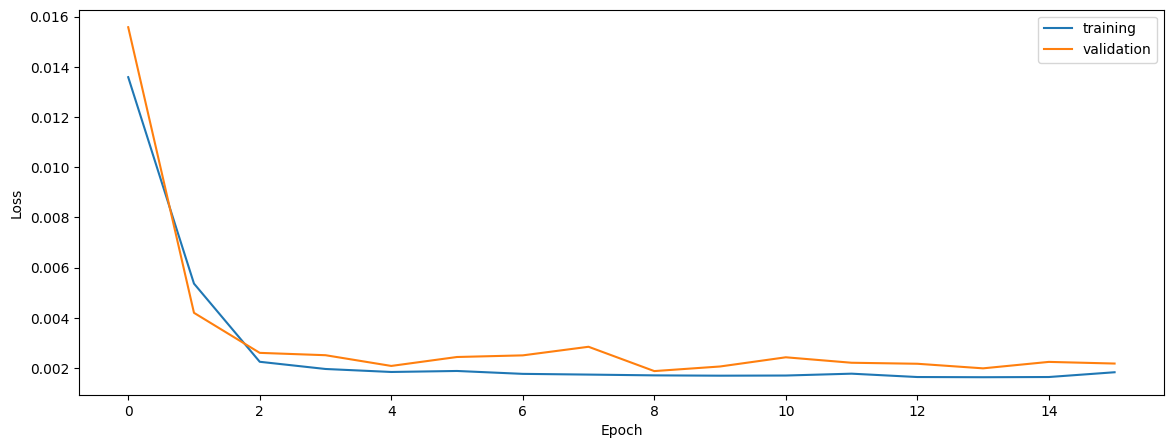

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


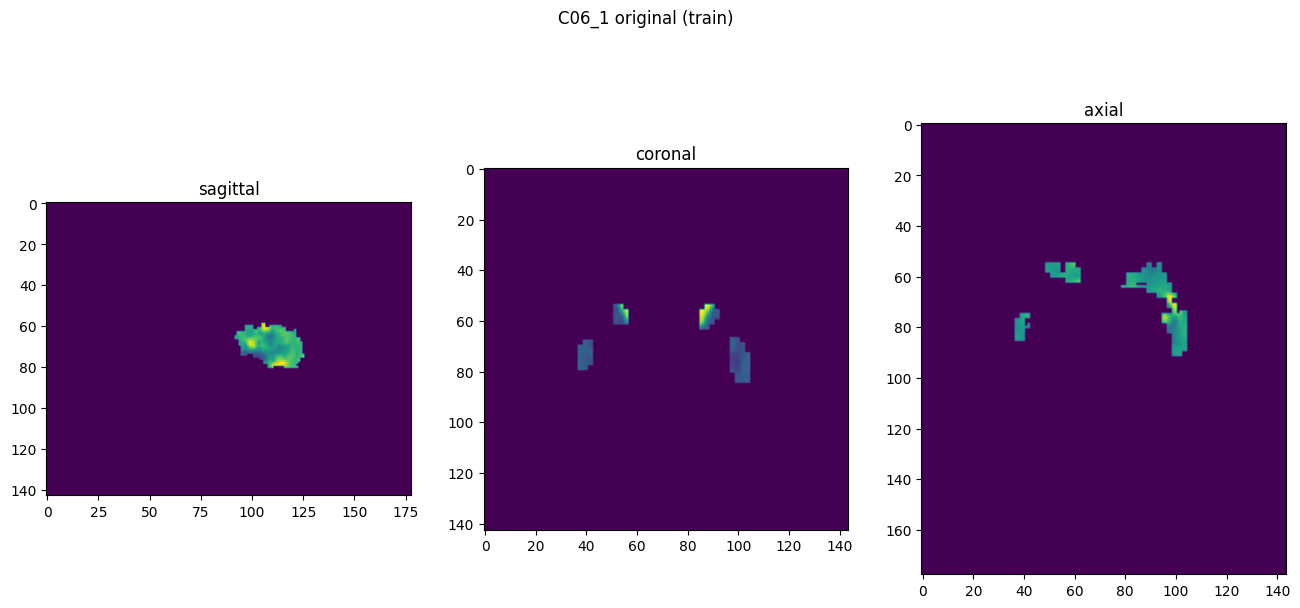

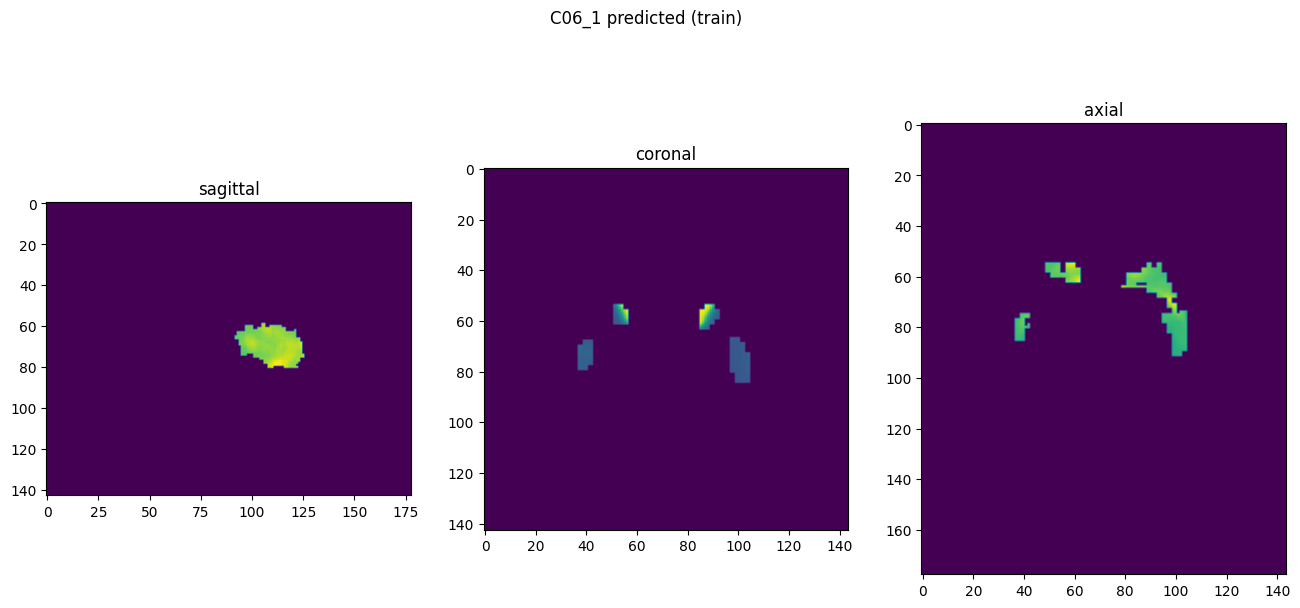

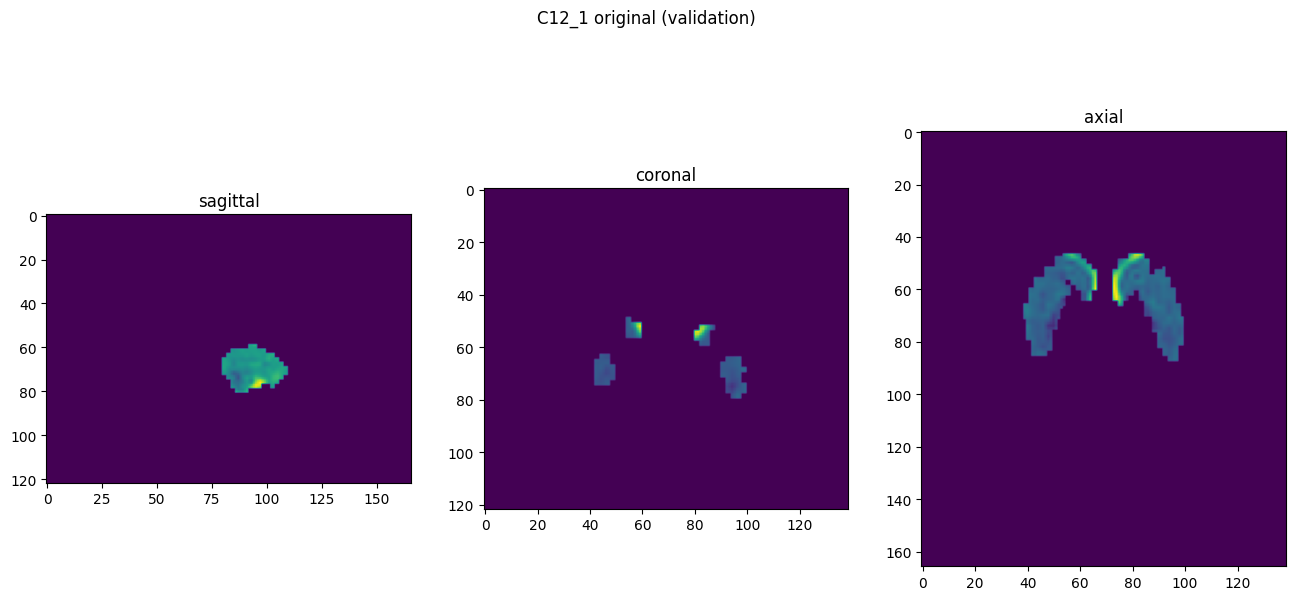

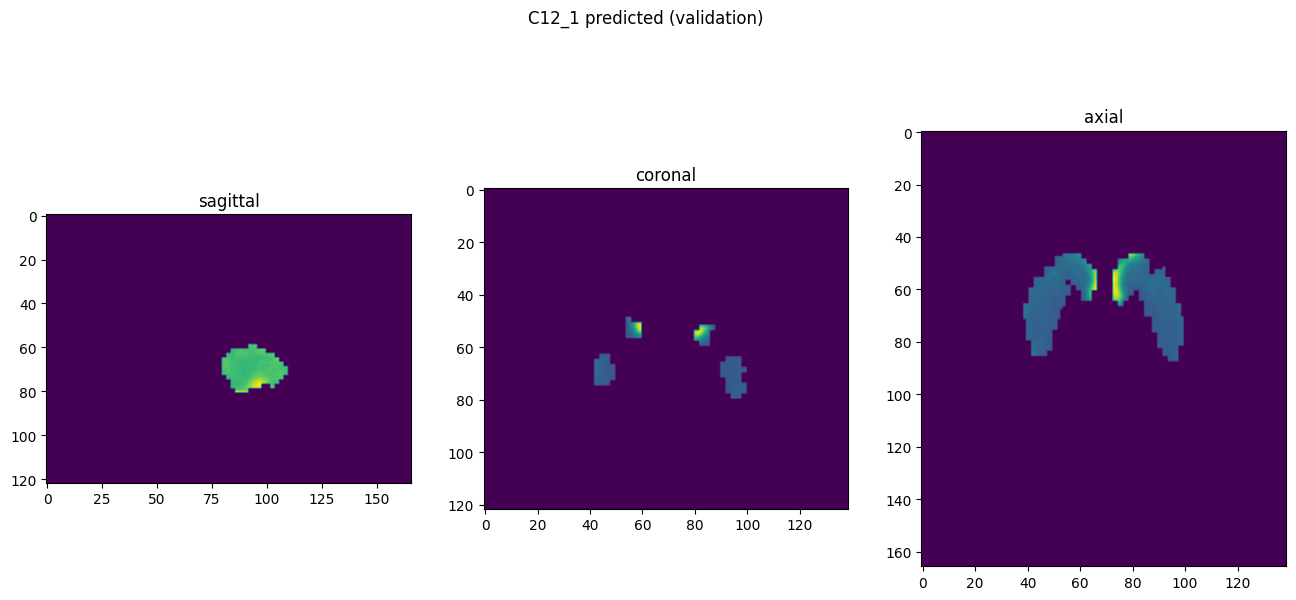

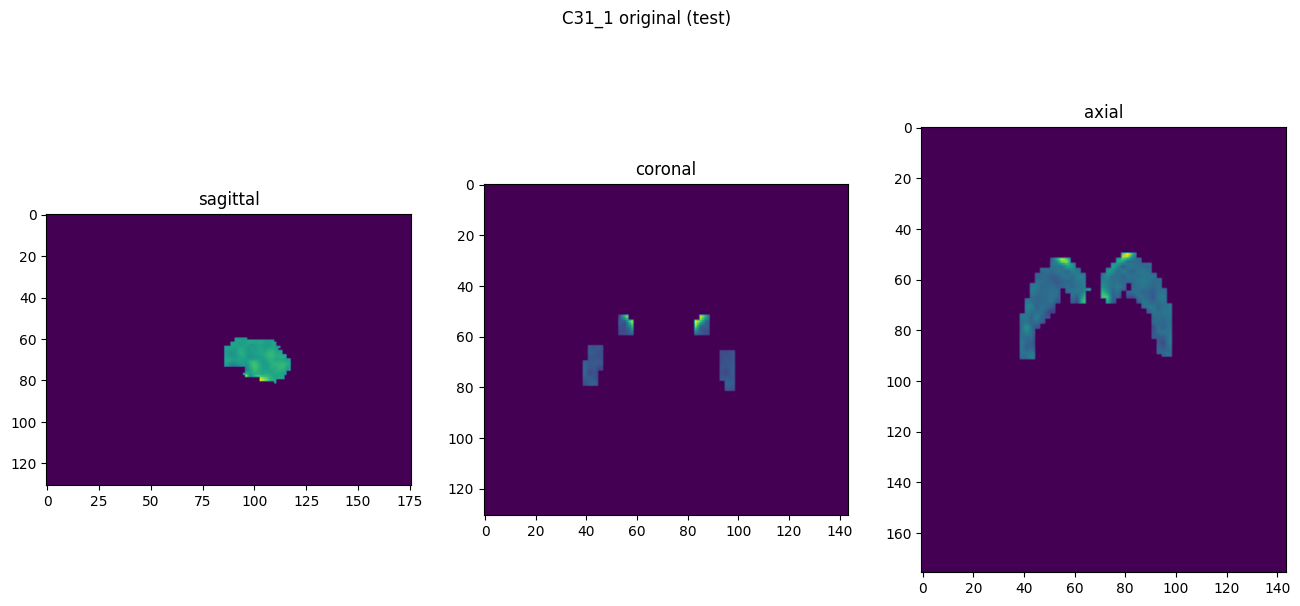

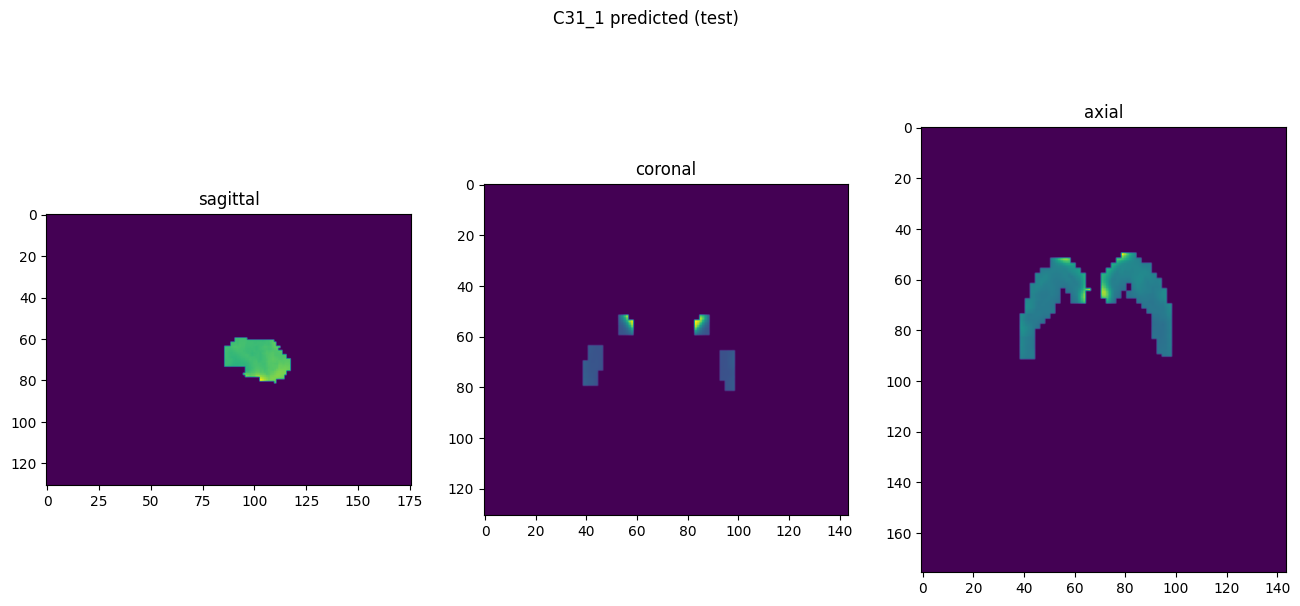

In [10]:
showResults(model, gen, threshold=None, background=False)